In [197]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [517]:
%matplotlib notebook

## Single Integrator, Linear Consensus

In [357]:
dt = 0.2
def single_int_sim(x0, T, controller):
    xtraj, utraj = [x0], []
    for _ in range(T):
        x = xtraj[-1]
        u = controller(x)
        x_new = x + dt * u
        xtraj.append(x_new)
        utraj.append(u)
    return np.array(xtraj), np.array(utraj)

In [358]:
def LCP_ctrl(x):
    n = len(x)
    u = (x.sum() - x) / (n-1) - x
    return u

<IPython.core.display.Javascript object>


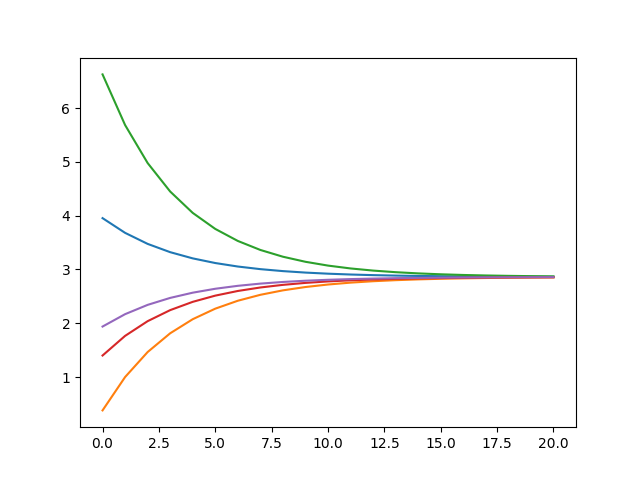

In [518]:
N = 5
T = 20
x0 = (np.random.random(N) * 10)[:,None]
xtraj, utraj = single_int_sim(x0, T, LCP_ctrl)
for i in range(N):
    plt.plot(np.arange(T+1), xtraj[:,i])

## Create LCP trajectory dataset to imitate

In [480]:
##############################
num_data = 200
N = 5
T = 20
##############################
x_data, u_data = [], []
for _ in range(num_data):
    x0 = np.random.random(N) * 10
    x, u = single_int_sim(x0, T, LCP_ctrl)
    x_data.append(x)
    u_data.append(u)
x_data = torch.tensor(x_data).type(torch.FloatTensor).unsqueeze(-1).requires_grad_(False)
u_data = torch.tensor(u_data).type(torch.FloatTensor).unsqueeze(-1).requires_grad_(False)
# Note that the unsqueeze comes from the fact that we are dealing with
# scaler states

## Create Vanilla GRNN Model

In [461]:
class GRNN(nn.Module):
    def __init__(self, N, T, p=1, q=1, h=5):
        super().__init__()
        self.N, self.T, self.p, self.q, self.h = N, T, p, q, h
        # Initialize S so that it is stochastic
        initial_S = torch.rand((N,N))
        initial_S = initial_S / initial_S.sum(1)[:,None]
        #self.S = torch.ones((N,N)) / N
        self.register_parameter(name='S', param=torch.nn.Parameter(initial_S))
        self.register_parameter(name='A', param=torch.nn.Parameter(torch.randn(p,h)))
        self.register_parameter(name='B', param=torch.nn.Parameter(torch.randn(h,q)))
        
    def graph_conv(self, X, Z):
        Z_new = torch.tanh( torch.matmul(self.S, Z) + torch.matmul(X, self.A) )
        #Z_new = torch.matmul(self.S, Z) + torch.matmul(X, self.A)
        u = torch.mm(Z_new, self.B)
        return Z_new, u

    def forward(self, x):
        output = torch.empty((T, self.N, self.q))
        Z = torch.zeros(self.N, self.h)
        for t in range(T):
            Z, output[t] = self.graph_conv(x[t], Z)
        return output

## Train the model

In [462]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [463]:
def criterion(u, u_opt):
    error = ((u_opt - u)**2).sum()
    return error
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [529]:
def train_it(x_data, u_data, beta=1):
    num_data = x_data.size()[0]
    error = 0
    for i in range(num_data):
        u = model.forward(x_data[i])
        error += criterion(u, u_data[i])
    regularization = torch.norm(model.S,1)
    loss = error / num_data + beta * regularization
    return loss

In [530]:
def train_model(x_data, u_data, optimizer, beta=1, num_epoch=100, verbose=False):
    
    model = GRNN(N, T)
    x_data = x_data.to(device)
    u_data = u_data.to(device)
    model = model.to(device)
    for epoch in range(num_epoch):
        loss = train_it(x_data, u_data, beta)
        if(verbose):
            print('Epoch: {} \t Loss: {}'.format(epoch+1, loss.item()))
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
    return model

In [ ]:
model = train_model(x_data, u_data, optimizer, beta=0.01, num_epoch=200, verbose=True)

## Test the Model Output Trajectory

In [467]:
class GRNNController():
    def __init__(self, model, T):
        self.S, self.A, self.B = model.S.detach().numpy(), \
            model.A.detach().numpy(),model.B.detach().numpy()
        self.n, self.p, self.q, self.h = \
            self.S.shape[0], self.S.shape[1], self.B.shape[1], self.A.shape[1]
        self.Z = np.zeros((self.n,self.h))
    def control(self, x):
        self.Z = self.S @ self.Z + x @ self.A
        self.Z = np.tanh(self.Z)
        return self.Z @ self.B
    def reset(self):
        self.Z = np.zeros((self.n,self.h))

<IPython.core.display.Javascript object>


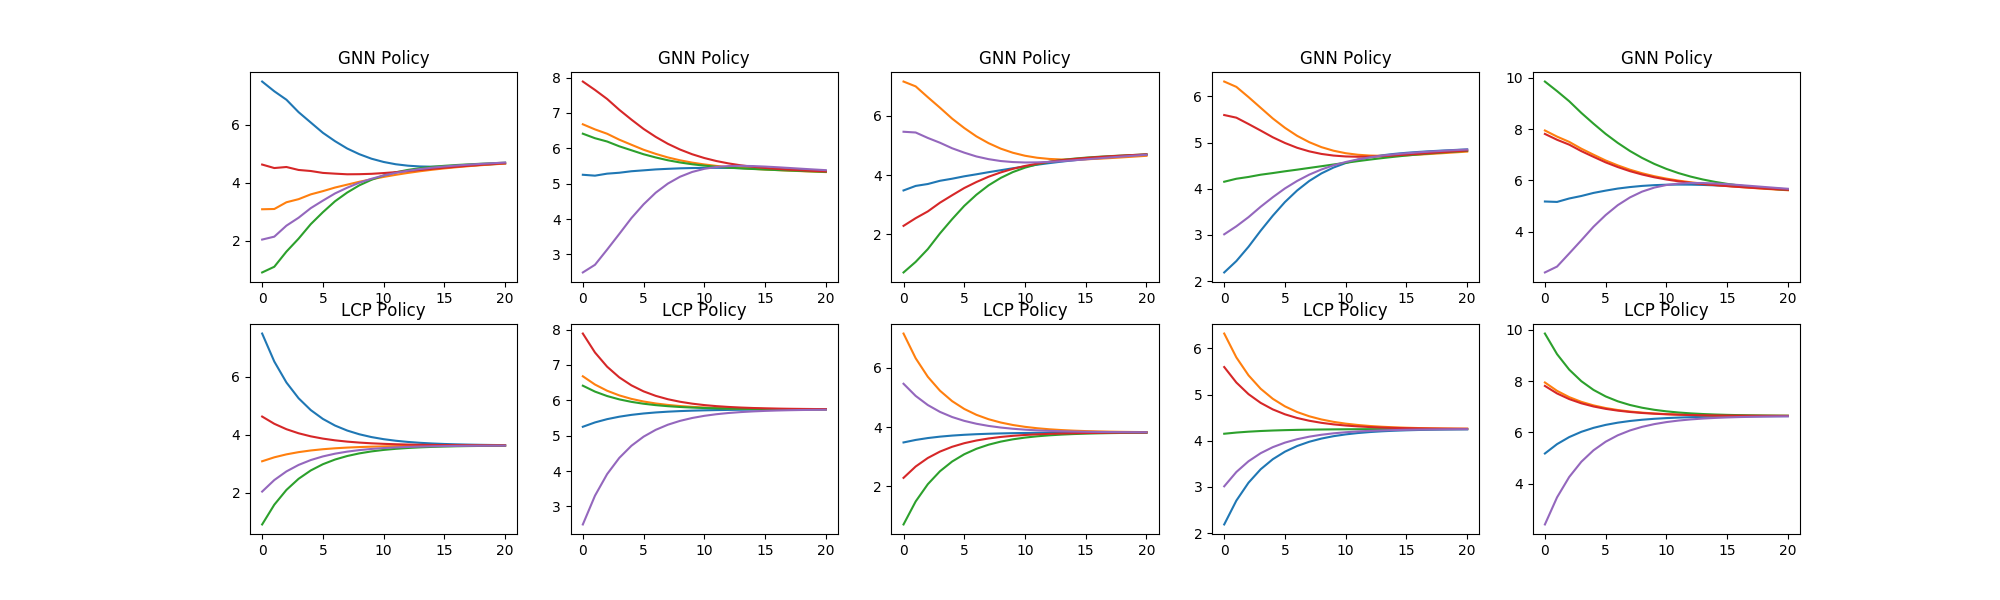

In [519]:
# Test the model on several random initial conditions
num_conditions = 5
gcontrol = GRNNController(model, T)

# Plot the trajectories
plt.figure(figsize=(20,6))
for k in range(num_conditions):
    x0 = (np.random.random(N) * 10)[:,None]
    gnnxtraj, gnnutraj = single_int_sim(x0, T, gcontrol.control)
    plt.subplot(2,num_conditions,k+1)
    for i in range(N):
        plt.plot(np.arange(T+1), gnnxtraj[:,i])
    plt.title('GNN Policy')
    
    lcpxtraj, lcputraj = single_int_sim(x0, T, LCP_ctrl)
    plt.subplot(2,num_conditions,num_conditions+k+1)
    for i in range(N):
        plt.plot(np.arange(T+1), lcpxtraj[:,i])
    plt.title('LCP Policy')
plt.savefig('result1.jpg', dpi=200)

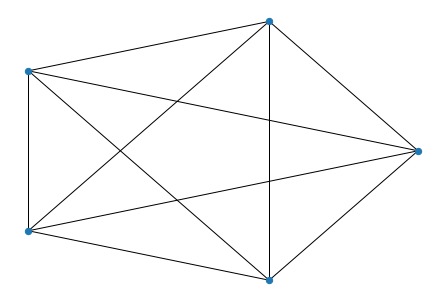

In [511]:
# Visualize the graph
import networkx as nx
G = nx.convert_matrix.from_numpy_matrix(gcontrol.S)
nx.draw_circular(G, node_size=40)

<IPython.core.display.Javascript object>


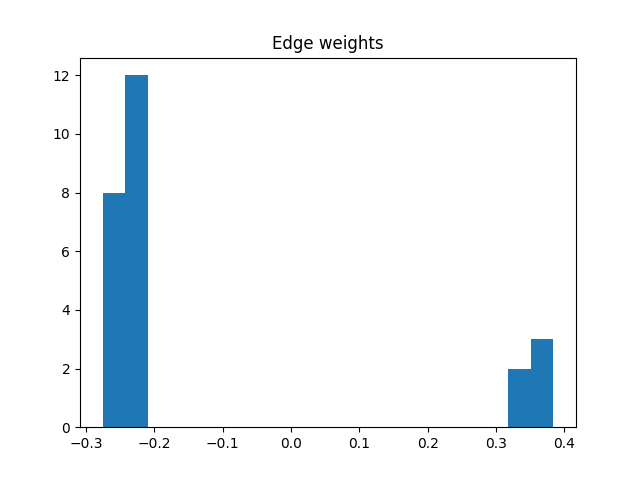

Text(0.5, 1.0, 'Edge weights')

In [520]:
# Visualize the distribution of weights in S
weights = gcontrol.S.flatten()
_ = plt.hist(weights, bins=20)
plt.title('Edge weights')

## Test regularization

In [532]:
betas = np.logspace(-2, 3, 5)
losses = []
weights = []
for beta in betas:
    model = train_model(x_data, u_data, optimizer, beta=beta, num_epoch=2, verbose=True)
    gcontrol = GRNNController(model, T)
    # Calculate the loss
    num_it = 100
    loss = 0
    for _ in range(num_it):
        x0 = (np.random.random(N) * 10)[:,None]
        gnnxtraj, gnnutraj = single_int_sim(x0, T, gcontrol.control)
        lcpxtraj, lcputraj = single_int_sim(x0, T, LCP_ctrl)
        loss += criterion(gnnutraj, lcputraj)
    loss /= num_it
    losses.append(loss)
    # Document the weights of the edges
    S = model.S.detach().numpy().flatten()
    weights.append(S)

Epoch: 1 	 Loss: 1264.1143798828125
Epoch: 2 	 Loss: 1264.1143798828125
Epoch: 1 	 Loss: 153.91343688964844
Epoch: 2 	 Loss: 153.91343688964844
Epoch: 1 	 Loss: 259.7049255371094
Epoch: 2 	 Loss: 259.7049255371094
Epoch: 1 	 Loss: 1261.9879150390625
Epoch: 2 	 Loss: 1261.9879150390625
Epoch: 1 	 Loss: 143.41778564453125
Epoch: 2 	 Loss: 143.41778564453125


<IPython.core.display.Javascript object>


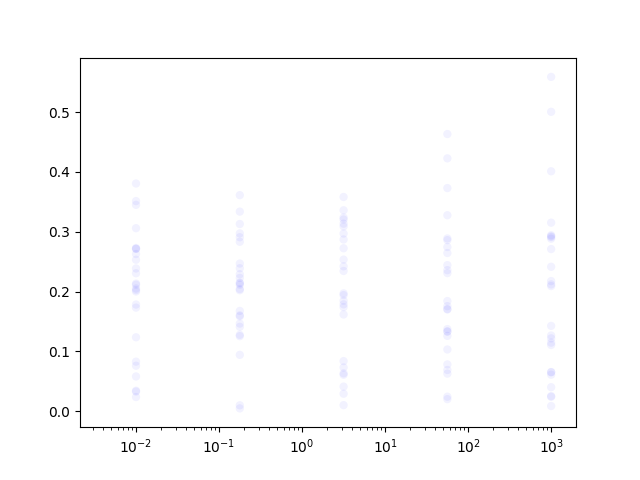

In [536]:
fig = plt.figure()
ax = plt.gca()
for i, beta in enumerate(betas):
    ax.scatter(np.ones(N*N)*beta, weights[i], c='blue', alpha=0.05, edgecolors='none')
    ax.set_xscale('log')